<a href="https://colab.research.google.com/github/GURJEW/tasks/blob/main/feature_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FEATURE MINING

Определение признаков
Оценка распределений признаков
Выделение зависимых и независимых переменных






## Иерархия базовых сущностей: токен -> реплика -> диалог
Базоые объекты речевой деятельности:
1. токен, в частном случае представлюющее лексему;
2. реплека - семпантически связанная последовательность лексем одного автора, ограниченноя непрерывным временным отрезгом;
3. диалог - диалектно связанная последовательность реплик двух и более авторов, раскрываюзие ограниченный набор аспектов заданной общей тематикию

## Типы признаков
* счётные, порядковые и ранговые - целочисленный от 0
* коничественно-оценочные - комплексное или десятичное число везвращаемое моделью или аггрегуриющей функцией
* неминально-категриальные - строка из заданного подмножества
* вещественный,тпорядковый, булевый или вектор комплексных чисел подкаласса featureList  

## Импорт библиотек и монтаж хранилища

In [1]:
import os
import json
import numpy as np
import pandas as pd

from collections import UserList
from itertools import product, zip_longest
from typing import Union, List

from plotly import graph_objects as go
from plotly.subplots import make_subplots as ms
from plotly import express as px
# from torch import softmax
from scipy.special import softmax
from scipy import stats
from scipy.stats import ttest_ind, friedmanchisquare, wilcoxon
from scipy.stats.morestats import shapiro
from sklearn.manifold import TSNE
from zipfile import ZipFile
from itertools import combinations

from google.colab import drive

gdrive = '/content/gdrive/'
project = 'My Drive/data/dialoger'
drive.mount(gdrive)
os.chdir(gdrive + project)
pd.set_option('display.max_colwidth', 120)


Mounted at /content/gdrive/


In [2]:
AKA = {
        'n': '_nominal',
        'c': '_cateerical',
        'd': '_numerical',
        'sk': '_speechkit',
        'bad_geo': 'ГЕО',
        'bad_legal': 'физ/юр.лицо',
        'bad_place': 'расположение ДЦ',
        'negative_perception': 'негатив',
        'no_budget': 'бюджет ',
        'non_targeted': 'нецелевой',
        'other_brand': 'другая марка',
        'other_model': 'другая модель',
        'second_hand': 'б/у',
        'time_purchase': 'срок покупки',
        'used': 'обращались в ОП / есть менеджер',
        'tag_01': 'приветствие',
        'tag_02': 'интерес',
        'tag_03': 'гео',
        'tag_04': 'обращение',
        'tag_05': 'утп',
        'tag_06': 'потребность',
        'tag_07': 'модель',
        'tag_08': 'физ/юрлицо',
        'tag_09': 'оплата',
        'tag_10': 'переключение',
        'dostoevsky_positive': 'positive',
        'dostoevsky_neutral': 'neutral',
        'dostoevsky_negative': 'negative',
        'dostoevsky_skip': 'unknown',
        'dostoevsky_speech': 'none'
    }


## Катгоризация 

In [31]:
def total_seconds(series):
    return pd.to_timedelta(series).dt.total_seconds()

def get_tone_value(tones):
    return tones.max() * tones.sum()

def parse(data, call_id):

    name_map = {
        'tag_01': 'приветствие',
        'tag_02': 'интерес',
        'tag_03': 'гео',
        'tag_04': 'обращение',
        'tag_05': 'утп',
        'tag_06': 'потребность',
        'tag_07': 'модель',
        'tag_08': 'физ/юрлицо',
        'tag_09': 'оплата',
        'tag_10': 'переключение',
        'dostoevsky_positive': 'positive',
        'dostoevsky_neutral': 'neutral',
        'dostoevsky_negative': 'negative',
        'dostoevsky_skip': 'unknown',
        'dostoevsky_speech': 'none'
    }

    df = pd.DataFrame(data)
    df['call_id'] = call_id
    df.start = total_seconds(df.start)
    df.end = total_seconds(df.end)
    df['duration'] = df.end - df.start
    df['letters'] = df.speech.str.replace(' ', '').str.len()
    df['words'] = df.speech.str.split(' ').apply(len)
    df['letter_tempo'] = df.letters / (df.duration + 1e-6)
    df['letters_over_words'] = df.letters / df.words
    words = df.groupby('speaker').words.sum() / df.words.sum()
    df = df.rename(columns=name_map)
    df['tone'] = df[['positive', 'neutral', 'negative', 'none', 'unknown']].idxmax(1)
    for speaker in words.index:
        df.loc[df.speaker == speaker, 'word_fraction'] = words[speaker]

    return df.drop(['emo_val', 'emo_aro'], 1)

def load(zip_path='pipeline_outputs.zip', versions=['1.5.0']):
    speeches = []
    with ZipFile(zip_path) as zf:
        names = zf.namelist()[1:]
        for name in names:
            with zf.open(name) as f:
                d = json.load(f)
            data = d.get('dialog')
            if (d.get('version') in versions) and data:
                speeches.append(parse(data, d['call_id']))
    return pd.concat(speeches, ignore_index=True)

def mask(df, treshord=0.2):
    return df.loc[df.duration > treshord]

In [30]:
features.columns

Index(['call_id', 'speech', 'speaker', 'interrupt', 'duration', 'word_tempo',
       'letter_tempo', 'words', 'letters', 'letters_over_words',
       'word_fraction', 'positive', 'neutral', 'negative', 'none', 'unknown',
       'tag_01', 'tag_02', 'tag_03', 'tag_04', 'tag_05', 'tag_06', 'tag_07',
       'tag_08', 'tag_09', 'tag_10', 'bad_geo', 'bad_legal', 'bad_place',
       'negative_perception', 'no_budget', 'non_targeted', 'other_brand',
       'other_model', 'second_hand', 'time_purchase', 'used'],
      dtype='object')

In [13]:
features = pd.read_csv('features.csv', index_col=0)

In [39]:
pd.read_csv('features.csv', index_col=0)

,call_id,speech,speaker,interrupt,duration,word_tempo,letter_tempo,words,letters,letters_over_words,...,bad_legal,bad_place,negative_perception,no_budget,non_targeted,other_brand,other_model,second_hand,time_purchase,used
scale,_nominal,_nominal,_cateerical,_numerical,_numerical,_numerical,_numerical,_numerical,_numerical,_numerical,...,_numerical,_numerical,_numerical,_numerical,_numerical,_numerical,_numerical,_numerical,_numerical,_numerical
source,_meta,_speechkit,_speechkit,_speechkit,_speechkit,_speechkit,_speechkit,_speechkit,_speechkit,_speechkit,...,_sbert,_sbert,_sbert,_sbert,_sbert,_sbert,_sbert,_sbert,_sbert,_sbert
method,_preset,_predict,_preset,_compute,_compute,_compute,_compute,_compute,_compute,_compute,...,_cos_max,_cos_max,_cos_max,_cos_max,_cos_max,_cos_max,_cos_max,_cos_max,_cos_max,_cos_max
kind,_name,_text,_agent,_time,_time,_time,_time,_count,_count,_count,...,_refusal,_refusal,_refusal,_refusal,_refusal,_refusal,_refusal,_refusal,_refusal,_refusal
feature,call_id,speech,speaker,interrupt,duration,word_tempo,letter_tempo,words,letters,letters_over_words,...,физ/юр.лицо,расположение ДЦ,негатив,бюджет,нецелевой,другая марка,другая модель,б/у,срок покупки,обращались в ОП / есть менеджер


In [40]:
features._features

AttributeError: ignored

In [47]:
# class Index(pd.MultiIndex.from_frame):

#     names = ('scale', 'source', 'method', 'kind', 'feature')


class Frame(pd.DataFrame):

    def __init__(self, *args, **kwargs):
        _features_ = pd.read_csv('features.csv', index_col=0)
        columns = pd.MultiIndex.from_frame(_features_)
        super().__init__(self, *args, **kwargs)
        # self._rename()


    @staticmethod
    def a(name):
        return AKA.get(name, name)


    # def __getattr__(self, name: str):
    #     # name = self.a(name)
    #     """
    #     After regular attribute access, try looking up the name
    #     This allows simpler access to columns for interactive use.
    #     """
    #     # Note: obj.x will always call obj.__getattribute__('x') prior to
    #     # calling obj.__getattr__('x').
    #     if (
    #         name not in self._internal_names_set
    #         and name not in self._metadata
    #         and name not in self._accessors
    #         and self._info_axis._can_hold_identifiers_and_holds_name(name)
    #     ):
    #         return self[name]
    #     return object.__getattribute__(self, name)

Frame()

AttributeError: ignored

In [38]:
Frame(load())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


RecursionError: ignored

In [11]:
pd.MultiIndex.from_frame(Frame.features.T)

MultiIndex([(   '_nominal',       '_meta',  '_preset',    '_name', ...),
            (   '_nominal',  '_speechkit', '_predict',    '_text', ...),
            ('_cateerical',  '_speechkit',  '_preset',   '_agent', ...),
            ( '_numerical',  '_speechkit', '_compute',    '_time', ...),
            ( '_numerical',  '_speechkit', '_compute',    '_time', ...),
            ( '_numerical',  '_speechkit', '_compute',    '_time', ...),
            ( '_numerical',  '_speechkit', '_compute',    '_time', ...),
            ( '_numerical',  '_speechkit', '_compute',   '_count', ...),
            ( '_numerical',  '_speechkit', '_compute',   '_count', ...),
            ( '_numerical',  '_speechkit', '_compute',   '_count', ...),
            ( '_numerical',  '_speechkit', '_compute',   '_count', ...),
            ( '_numerical', '_dostoevsky', '_predict',    '_tone', ...),
            ( '_numerical', '_dostoevsky', '_predict',    '_tone', ...),
            ( '_numerical', '_dostoevsky', '_predic

In [ ]:
index_names = ['scale', 'source', 'method', 'kind', 'feature']
index_dict = {
    ('_nominal', '_meta', '_preset', '_name'): ['call_id'],
    ('_nominal', '_speechkit', '_predict', '_text'): ['speech'],
    ('_cateerical', '_speechkit', '_preset', '_agent'): ['speaker'],
    ('_numerical', '_speechkit', '_compute', '_time'): ['interrupt', 'duration', 'word_tempo', 'letter_tempo' ],
    ('_numerical', '_speechkit', '_compute', '_count'): ['words', 'letters', 'letters_over_words', 'word_fraction'],
    ('_numerical', '_dostoevsky', '_predict', '_tone'): ['positive', 'neutral', 'negative', 'none', 'unknown'],
    ('_numerical', '_sbert', '_cos_max', '_topic'): [   'tag_01', 'tag_02', 'tag_03', 'tag_04', 'tag_05',
                                                        'tag_06', 'tag_07', 'tag_08', 'tag_09', 'tag_10'],
    ('_numerical', '_sbert', '_cos_max', '_refusal'): ['bad_geo', 'bad_legal', 'bad_place', 'negative_perception',
            'no_budget', 'non_targeted', 'other_brand', 'other_model',
            'second_hand', 'time_purchase', 'used']
    }

In [ ]:
np.array([index] * 3)

In [ ]:
features = pd.DataFrame(index=index_names)
for index, names in index_dict.items():
    features.loc[index_names[:-1], names] = np.array([index] * len(names)).T
features.loc['feature'] = features.columns.to_series(name='feature').apply(lambda feature: aka.get(feature, feature))
features.to_csv('features.csv')

In [ ]:
index = pd.MultiIndex.from_frame(features.T[index_names], names=index_names)

In [ ]:
index.levshape

In [ ]:
index.levels

In [ ]:
pd.Series(index_dict, name=index_names[-1]).apply(
    lambda features: [list(features.index) + [feature] for feature in features.values]
)

In [ ]:
name_dict = {
    ('nominal', 'based', 'name'): ['call_id'],
    ('cateerical', 'based', 'agent'): ['speaker'],
    ('numerical', 'computed', 'tempo'): ['interrupt', 'duration', 'word_tempo', 'letter_tempo' ],
    ('numerical', 'computed', 'count'): ['words', 'letters', 'letters_over_words', 'word_fraction'],
    ('numerical', 'predicted', 'tone'): ['positive', 'neutral', 'negative', 'none', 'unknown'],
    ('numerical', 'computed', 'tone'): ['positive', 'neutral', 'negative', 'none', 'unknown'],
    ('cateerical', 'computed', 'tone'): ['tone'],
    ('numerical', 'predicted', 'tags'): ['приветствие', 'интерес', 'гео', 'обращение', 'утп',
            'потребность', 'модель', 'физ/юрлицо', 'оплата', 'переключение' ],
    ('numerical', 'predicted', 'subs'): ['bad_geo', 'bad_legal', 'bad_place', 'negative_perception',
            'no_budget', 'non_targeted', 'other_brand', 'other_model',
            'second_hand', 'time_purchase', 'used'],

    ('nominal', 'featured', '_index'): ['scale', 'source', 'kind'],
    ('nominal', 'featured', '_map'): [
        'describe',
        'count',
        'sum',
        'cumsum',
        'min',
        'max',
        'median',
        'mean',
        'std',
        'var'
        ]
    }

In [ ]:
features = pd.Series(
    data=index_dict.values(),
    index=pd.MultiIndex.from_tuples(
        index_dict.keys(),
        names=('nominal', 'featured', '_index')
        ),
    name='features'
)
features

In [ ]:
features.swaplevel(0, 1)

source     scale       kind  
based      nominal     name                                                                                                                    [call_id]
           cateerical  agent                                                                                                                   [speaker]
computed   numerical   tempo                                                                             [interrupt, duration, word_tempo, letter_tempo]
                       count                                                                         [words, letters, letters_over_words, word_fraction]
predicted  numerical   tone                                                                                 [positive, neutral, negative, none, unknown]
computed   numerical   tone                                                                                 [positive, neutral, negative, none, unknown]
           cateerical  tone                         

## Загрузка данных

In [ ]:
df = mask(load())
df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


(6365, 40)

In [ ]:
groups = features.swaplevel(0, 1).based.sum()
groups

['call_id', 'speaker']

In [ ]:
if (df[names].sum(1).round(6) !=  1).any():
    df[names] = softmax(df[names].values, 1)
(df[names].sum(1).round(6) ==  1).all()

True

In [ ]:
grouped = df[names + groups].groupby(groups).max().reset_index(1)
for name in names:
    fig = px.histogram(
        grouped,
        x=name,
        color=groups[1],
        title=name
        )
    fig.show()

In [ ]:
grouped = df[names + groups].groupby(groups).max().reset_index(1)
for name in names:
    fig = px.histogram(
        grouped,
        x=name,
        color=groups[1],
        title=name
        )
    fig.show()

In [ ]:
fig = px.histogram(
    df[names + groups].groupby(groups).max().reset_index(1),
    x=names[3],
    color=groups[1]
    )
fig.show()


In [ ]:
df.groupby('call_id').приветствие.describe().describe()

,count,mean,std,min,25%,50%,75%,max
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,28.600877,0.633047,0.104909,0.429830,0.576753,0.628533,0.687267,0.874534
std,13.093476,0.024652,0.018823,0.057090,0.030545,0.023295,0.030002,0.077947
min,6.000000,0.547813,0.049473,0.296305,0.440025,0.535436,0.622825,0.644499
25%,20.000000,0.615978,0.092082,0.387541,0.563382,0.614417,0.666386,0.841279
50%,26.000000,0.632460,0.105172,0.435076,0.581988,0.628282,0.683423,0.841279
75%,34.000000,0.648452,0.116745,0.449491,0.593494,0.641877,0.700732,0.921834
max,104.000000,0.722728,0.163957,0.616810,0.644970,0.716285,0.828249,1.000001


In [ ]:
df.groupby('call_id').bad_geo.describe()

,count,mean,std,min,25%,50%,75%,max
call_id,,,,,,,,
mix_13052_16e002__2022_02_20__10_25_04_310,22.0,0.549676,0.110255,0.332764,0.458193,0.581970,0.615996,0.731194
mix_13052_16e005__2022_02_15__19_40_54_370,31.0,0.576282,0.089828,0.335627,0.532960,0.575205,0.647790,0.699726
mix_13052_16e011__2022_02_10__20_02_20_263,24.0,0.630173,0.103370,0.356180,0.582472,0.624959,0.689255,0.820154
mix_13052_16e014__2022_02_07__13_48_13_593,18.0,0.596574,0.071292,0.426169,0.550959,0.595436,0.648599,0.704122
mix_13052_16e014__2022_02_16__09_21_53_923,23.0,0.612032,0.094204,0.393485,0.554765,0.616938,0.659537,0.795893
...,...,...,...,...,...,...,...,...
mix_13090_16e032__2022_02_10__10_29_04_010,35.0,0.603991,0.091219,0.381347,0.551872,0.607324,0.670458,0.776601
mix_13091_16e009__2022_02_10__11_00_52_273,55.0,0.621386,0.062364,0.492018,0.575121,0.619392,0.666355,0.805654
mix_13093_16e016__2022_02_15__09_18_21_417,26.0,0.608266,0.073805,0.362137,0.589124,0.614354,0.651131,0.705268


In [ ]:
df.groupby('call_id').bad_geo.max()

call_id
mix_13052_16e002__2022_02_20__10_25_04_310    0.731194
mix_13052_16e005__2022_02_15__19_40_54_370    0.699726
mix_13052_16e011__2022_02_10__20_02_20_263    0.820154
mix_13052_16e014__2022_02_07__13_48_13_593    0.704122
mix_13052_16e014__2022_02_16__09_21_53_923    0.795893
                                                ...   
mix_13090_16e032__2022_02_10__10_29_04_010    0.776601
mix_13091_16e009__2022_02_10__11_00_52_273    0.805654
mix_13093_16e016__2022_02_15__09_18_21_417    0.705268
mix_13095_16e028__2022_02_15__12_30_51_400    0.744138
mix_13105_16e014__2022_02_07__10_23_34_487    0.737302
Name: bad_geo, Length: 228, dtype: float64

In [ ]:
def plot_feature(feature):
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=np.arange(df.call_id.nunique()),
            y=sorted(df.groupby('call_id').agg(
                {feature: 'max'}
            )[feature].to_list())
        )
    )
    fig.show()

In [ ]:
for feature in features.numerical.predicted['sub']:
    print(f'\n\n{feature}')
    plot_feature(feature)



bad_geo




bad_legal




bad_place




negative_perception




no_budget




non_targeted




other_brand




other_model




second_hand




time_purchase




used


In [ ]:
for feature in features.numerical.predicted['tag']:
    print(f'\n\n{feature}')
    plot_feature(feature)



приветствие




интерес




гео




обращение




утп




потребность




модель




физ/юрлицо




оплата




переключение


In [ ]:
def drop_indices(index):
    return df.loc[~df.index.isin(index)].index

In [ ]:
def get_word_share(index):
    return pd.Series(
        df.loc[index].speech.str.split(' ').sum(),
        name='words'
        ).value_counts()

In [ ]:
def group(df, by_list):
    return pd.Series(df.groupby(by_list).groups)

In [ ]:
def is_normal(word_shares):    
    return word_shares.apply(
        lambda x: shapiro(x.dropna())
        ).round(6).T

In [ ]:
by_list = features.cateerical.sum()
grouped = group(df, by_list)
indices = pd.concat(
    [
        pd.Series({('', ''): df.index}),
        grouped,
        grouped.apply(drop_indices)
        ],
    keys=['total', 'inner', 'outer']
)


In [ ]:
word_shares = indices.apply(get_word_share).T

In [ ]:
word_shares.head()

total    inner                                                        \
             abonent                                operator                 
            negative neutral  none positive unknown negative neutral  none   
в    2026.0    185.0   167.0  25.0    126.0   148.0    427.0   286.0  87.0   
да   1520.0    320.0   277.0  50.0    138.0    89.0    222.0   158.0  45.0   
я    1482.0    209.0   102.0  24.0    154.0   166.0    284.0   127.0  57.0   
вас  1417.0    100.0   123.0  25.0     92.0   101.0    228.0   246.0  94.0   
а    1238.0    129.0   154.0   7.0     57.0   135.0    178.0   228.0  23.0   

              ...    outer                                                    \
              ...  abonent                                  operator           
    positive  ... negative neutral    none positive unknown negative neutral   
в      250.0  ...   1841.0  1859.0  2001.0   1900.0  1878.0   1599.0  1740.0   
да     109.0  ...   1200.0  1243.0  1470.0   1382.0  1431.0   1298.0  1362.0   
я      191.0  ...   1273.0  1380.0  1458.0   1328.0  1316.0   1198.0  1355.0   
вас    212.0  ...   1317.0  1294.0  1392.0   1325.0  1316.0   1189.0  1171.0   
а      119.0  ...   1109.0  1084.0  1231.0   1181.0  1103.0   1060.0  1010.0   

                              
                              
       none positive unknown  
в    1939.0   1776.0  1701.0  
да   1475.0   1411.0  1408.0  
я    1425.0   1291.0  1314.0  
вас  1323.0   1205.0  1221.0  
а    1215.0   1119.0  1030.0  

[5 rows x 21 columns]

In [ ]:
word_shares.describe()

total        inner                                        \
                        abonent                                         
                       negative      neutral        none     positive   
count  4946.000000  1618.000000  1174.000000  399.000000  1219.000000   
mean     13.929236     5.077256     4.873935    3.661654     4.054143   
std      73.048823    17.960400    15.678879    8.090152    11.014710   
min       1.000000     1.000000     1.000000    1.000000     1.000000   
25%       1.000000     1.000000     1.000000    1.000000     1.000000   
50%       2.000000     1.000000     1.000000    1.000000     1.000000   
75%       5.000000     3.000000     3.000000    3.000000     3.000000   
max    2026.000000   320.000000   277.000000   89.000000   154.000000   

                                                                       ...  \
                       operator                                        ...   
           unknown     negative      neutral        none     positive  ...   
count  1323.000000  2076.000000  1427.000000  646.000000  1516.000000  ...   
mean      4.176115     6.356936     6.016118    4.648607     5.508575  ...   
std      11.443605    21.045361    18.456549   11.220360    15.732728  ...   
min       1.000000     1.000000     1.000000    1.000000     1.000000  ...   
25%       1.000000     1.000000     1.000000    1.000000     1.000000  ...   
50%       1.000000     1.000000     1.000000    1.000000     2.000000  ...   
75%       3.000000     3.000000     4.000000    3.000000     4.000000  ...   
max     166.000000   427.000000   286.000000  131.000000   250.000000  ...   

             outer                                                      \
           abonent                                                       
          negative      neutral         none     positive      unknown   
count  4548.000000  4748.000000  4918.000000  4716.000000  4681.000000   
mean     13.341909    13.304971    13.711468    13.560645    13.537492   
std      66.443104    67.452711    71.861523    69.399047    69.090916   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       1.000000     1.000000     1.000000     1.000000     1.000000   
50%       2.000000     2.000000     2.000000     2.000000     2.000000   
75%       5.000000     5.000000     5.000000     5.000000     5.000000   
max    1841.000000  1859.000000  2001.000000  1900.000000  1878.000000   

                                                                        
          operator                                                      
          negative      neutral         none     positive      unknown  
count  4403.000000  4698.000000  4886.000000  4658.000000  4597.000000  
mean     12.649784    12.837165    13.485673    12.997638    12.834675  
std      63.219327    65.237618    70.575048    66.584245    65.632058  
min       1.000000     1.000000     1.000000     1.000000     1.000000  
25%       1.000000     1.000000     1.000000     1.000000     1.000000  
50%       2.000000     2.000000     2.000000     2.000000     2.000000  
75%       5.000000     5.000000     5.000000     5.000000     5.000000  
max    1599.000000  1740.000000  1939.000000  1776.000000  1701.000000  

[8 rows x 21 columns]

In [ ]:
is_narmal(word_shares)

In [ ]:

shapiro()

In [ ]:

word_shares = pd.concat(
    [word_shares.T.describe(), word_shares],
    axis=1,
    keys=['statistic', 'words']
)

AssertionError: ignored

In [ ]:
word_shares.T.describe()

statistic                                                          \
             count       mean        std   min   25%        50%        75%   
count    21.000000  21.000000  21.000000  21.0  21.0  21.000000  21.000000   
mean   3088.666667   9.357416  42.706314   1.0   1.0   1.571429   4.190476   
std    1775.927119   4.280458  27.461872   0.0   0.0   0.507093   0.928388   
min     399.000000   3.661654   8.090152   1.0   1.0   1.000000   3.000000   
25%    1427.000000   5.077256  15.732728   1.0   1.0   1.000000   3.000000   
50%    4403.000000  12.649784  63.219327   1.0   1.0   2.000000   5.000000   
75%    4698.000000  13.341909  67.452711   1.0   1.0   2.000000   5.000000   
max    4946.000000  13.929236  73.048823   1.0   1.0   2.000000   5.000000   

                          words               ...                \
               max            в           да  ... сертификатная   
count    21.000000    21.000000    21.000000  ...          11.0   
mean   1080.238095  1061.238095   796.190476  ...           1.0   
std     826.587981   847.703008   636.391359  ...           0.0   
min      89.000000    25.000000    45.000000  ...           1.0   
25%     277.000000   185.000000   138.000000  ...           1.0   
50%    1599.000000  1599.000000  1200.000000  ...           1.0   
75%    1859.000000  1859.000000  1408.000000  ...           1.0   
max    2026.000000  2026.000000  1520.000000  ...           1.0   

                                                                   \
      переспрашивать  шина представленки конкретнее близинг  вряд   
count           11.0  11.0          11.0       11.0    11.0  11.0   
mean             1.0   1.0           1.0        1.0     1.0   1.0   
std              0.0   0.0           0.0        0.0     0.0   0.0   
min              1.0   1.0           1.0        1.0     1.0   1.0   
25%              1.0   1.0           1.0        1.0     1.0   1.0   
50%              1.0   1.0           1.0        1.0     1.0   1.0   
75%              1.0   1.0           1.0        1.0     1.0   1.0   
max              1.0   1.0           1.0        1.0     1.0   1.0   

                                     
      ориентировали обратимся   дск  
count          11.0      11.0  11.0  
mean            1.0       1.0   1.0  
std             0.0       0.0   0.0  
min             1.0       1.0   1.0  
25%             1.0       1.0   1.0  
50%             1.0       1.0   1.0  
75%             1.0       1.0   1.0  
max             1.0       1.0   1.0  

[8 rows x 4954 columns]

In [ ]:
word_shares = [get_word_share(df.speech)]

In [ ]:
for group, index in indices.items():
    get_word_share(df.speech[index])
    word_shares.loc[index, group] = 

In [ ]:
for left, right in combinations(groups.keys(), 2):
    result = wilcoxon(df.speech[groups[left]], df.speech[groups[right]])
    print(f'{left, right}: {result}')

ValueError: ignored

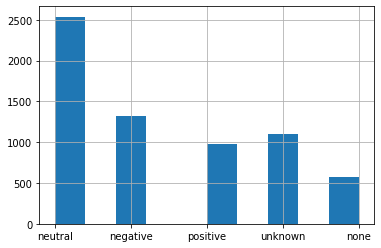

In [ ]:
df[names.tones[:-1]].tone.hist()

In [ ]:
# class Direct(dict):

#     def __init__(self):
#         self.data = data.speech.sum().value_colnts()
        
        
        
        

#     def estimate(self, groups, by, methods):
        

AttributeError: ignored

In [ ]:
def get_word_share(series):
    return pd.Series(series.str.split(' ').sum()).value_counts(normalize=True).sort_index()

In [ ]:
word_share = get_word_share(df.speech).to_frame(('general', 'share'))

In [ ]:
for key, index, in df.groupby(['speaker', 'tone']).groups.items():
    share = get_word_share(df.loc[index].speech)
    word_share.loc[share.index, key] = share.values

In [ ]:
word_share

general   abonent                                          \
                share  negative   neutral      none  positive   unknown   
а            0.017970  0.015703  0.026914  0.004791  0.011534  0.024434   
абсолютно    0.000102  0.000365  0.000175       NaN       NaN       NaN   
авар         0.000015       NaN       NaN       NaN       NaN       NaN   
авиадопку    0.000015       NaN       NaN       NaN       NaN       NaN   
авиационная  0.000015       NaN       NaN       NaN       NaN       NaN   
...               ...       ...       ...       ...       ...       ...   
ярославское  0.000189  0.000487  0.000350       NaN       NaN       NaN   
ярославском  0.000058       NaN  0.000175       NaN       NaN  0.000181   
яротам       0.000015       NaN       NaN       NaN       NaN       NaN   
ясенево      0.000029       NaN       NaN       NaN       NaN  0.000362   
ясно         0.000102       NaN  0.000175  0.000684  0.000202       NaN   

             operator                                         
             negative   neutral      none positive   unknown  
а            0.013488  0.026558  0.007659  0.01425  0.021025  
абсолютно    0.000152  0.000116       NaN      NaN       NaN  
авар         0.000076       NaN       NaN      NaN       NaN  
авиадопку    0.000076       NaN       NaN      NaN       NaN  
авиационная  0.000076       NaN       NaN      NaN       NaN  
...               ...       ...       ...      ...       ...  
ярославское       NaN  0.000466       NaN  0.00012  0.000202  
ярославском  0.000076       NaN       NaN      NaN  0.000101  
яротам       0.000076       NaN       NaN      NaN       NaN  
ясенево           NaN       NaN       NaN      NaN       NaN  
ясно              NaN  0.000116       NaN  0.00012  0.000202  

[4946 rows x 11 columns]

In [ ]:
df.loc[index]

,speech,speaker,word_tempo,interrupt,start,end,neutral,unknown,negative,none,...,time_purchase,used,call_id,duration,letters,words,letter_tempo,letters_over_words,word_fraction,tone
38,ну да,abonent,4.55,-0.72,127.10,127.540,0.039,0.007,0.046,0.000,...,0.595628,0.530352,mix_13052_16e005__2022_02_15__19_40_54_370,0.440,4,2,9.090888,2.000000,0.247012,negative
49,митсубиси как машина я больно не рассматривавшийся,abonent,2.24,-1.00,190.84,193.960,0.016,0.055,0.119,0.002,...,0.706649,0.591123,mix_13052_16e005__2022_02_15__19_40_54_370,3.120,44,7,14.102560,6.285714,0.247012,negative
66,нет да я не обращался неизвестно куда попало,abonent,3.03,-0.23,26.03,28.670,0.064,0.036,0.232,0.000,...,0.742732,0.711712,mix_13052_16e011__2022_02_10__20_02_20_263,2.640,37,8,14.015146,4.625000,0.329897,negative
68,не ну если не одобрили бы я же не могу так как я,abonent,5.06,-1.68,46.72,49.288,0.034,0.054,0.144,0.000,...,0.659836,0.636737,mix_13052_16e011__2022_02_10__20_02_20_263,2.568,36,13,14.018686,2.769231,0.329897,negative
70,так ну и вот условия просмотрел кредитования бы это самих цен да зависит правильно же вас понимаю,abonent,3.92,0.06,49.71,54.050,0.039,0.031,0.072,0.001,...,0.716553,0.568846,mix_13052_16e011__2022_02_10__20_02_20_263,4.340,81,17,18.663590,4.764706,0.329897,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6450,меня зовут екатерина из компании автомир богемия официального дилера шкода в ярославле скажите планируете покупку ав...,abonent,2.82,-0.44,4.56,11.660,0.044,0.052,0.063,0.001,...,0.539590,0.576667,mix_13093_16e016__2022_02_15__09_18_21_417,7.100,129,20,18.169012,6.450000,0.667656,negative
6464,ну здесь в любом случае надо сравнивать потому что ну разговаривать с менеджерами отдела продаж потому что на сайтах...,abonent,3.24,-1.42,89.89,96.990,0.048,0.021,0.093,0.002,...,0.649391,0.649063,mix_13093_16e016__2022_02_15__09_18_21_417,7.100,126,23,17.746476,5.478261,0.667656,negative
6476,да ну я заезжал хавейл там в автомир да ну к сожалению ну не кино я,abonent,2.42,-1.16,6.95,13.560,0.020,0.121,0.416,0.000,...,0.701997,0.723373,mix_13095_16e028__2022_02_15__12_30_51_400,6.610,52,16,7.866867,3.250000,0.310078,negative
6493,да да да,abonent,3.30,-0.50,104.87,105.778,0.057,0.002,0.084,0.000,...,0.517632,0.474695,mix_13095_16e028__2022_02_15__12_30_51_400,0.908,6,3,6.607922,2.000000,0.310078,negative


In [ ]:
pd.Series({'word': df.speech.str.split(' ').sum()})

word    [алло, меня, зовут, алина, я, представляю, автомир, байкальская, официального, дилера, джили, в, москве, мы, звоним,...
dtype: object

In [ ]:
df[df.tone]

,neutral,negative,neutral,negative,negative,neutral,positive,unknown,positive,neutral,...,neutral,negative,neutral,negative,unknown,negative,neutral,unknown,none,none
0,0.054,0.000,0.054,0.000,0.000,0.054,0.000,0.014,0.000,0.054,...,0.054,0.000,0.054,0.000,0.014,0.000,0.054,0.014,0.000,0.000
1,0.030,0.162,0.030,0.162,0.162,0.030,0.050,0.058,0.050,0.030,...,0.030,0.162,0.030,0.162,0.058,0.162,0.030,0.058,0.013,0.013
2,0.054,0.001,0.054,0.001,0.001,0.054,0.002,0.052,0.002,0.054,...,0.054,0.001,0.054,0.001,0.052,0.001,0.054,0.052,0.000,0.000
3,0.045,0.083,0.045,0.083,0.083,0.045,0.079,0.049,0.079,0.045,...,0.045,0.083,0.045,0.083,0.049,0.083,0.045,0.049,0.005,0.005
4,0.041,0.109,0.041,0.109,0.109,0.041,0.030,0.050,0.030,0.041,...,0.041,0.109,0.041,0.109,0.050,0.109,0.041,0.050,0.001,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6516,0.048,0.073,0.048,0.073,0.073,0.048,0.013,0.038,0.013,0.048,...,0.048,0.073,0.048,0.073,0.038,0.073,0.048,0.038,0.001,0.001
6517,0.051,0.000,0.051,0.000,0.000,0.051,0.000,0.001,0.000,0.051,...,0.051,0.000,0.051,0.000,0.001,0.000,0.051,0.001,0.000,0.000
6518,0.043,0.060,0.043,0.060,0.060,0.043,0.016,0.072,0.016,0.043,...,0.043,0.060,0.043,0.060,0.072,0.060,0.043,0.072,0.001,0.001
6519,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.000,...,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.003,0.459,0.459


## Вероятность соответствия распределения признаков реплик нормальному не привышает:

In [ ]:
shapiro_values = pd.DataFrame(
    [   stats.shapiro(speeches.sample(5000)[feature])
        for feature in featureS     ],
    featureS,
    VALUES
)
shapiro_values.p.max()

Выввлд: При таком значении параметрические оценки сравнения выборок некорректным.

In [ ]:
# speeches.loc[:TONES].apply(value_colnts)
# speeches.loc[:TONES].apply(value_colnts)
value_counts(speeches.loc[:TONES])

# Анализ уровня диалога 

## Отношение тональностей реплик

In [ ]:
def value_counts(series):
    return series.value_counts(normalize=True).rename(
        {name: f'fraction_{name}' for name in TONES}
        )

In [ ]:
value_counts(speeches.tone)

In [ ]:
speeches.groupby('speaker').tone.value_counts(normalize=True)

In [ ]:
speeches.set_index('speaker')[['speech', 'tone']].to_csv('speech_tone.csv')

In [ ]:
speeches[['speech', 'tone']].to_csv('speech_tone.csv')

## Получение профилей речи участников диалога

In [ ]:
def tone_dict(series):
    return series.loc[series.tone].to_dict()

In [ ]:
(set(TONES))& set((1, 2))

In [ ]:
def aggregate(speeches):
    speeches = speeches[GROUPS+featureS]
    speeches.columns = COLUMNS
    agg_map = {
        feature: STATS if feature[-1] not in TONES  else STATS + [tone_dict]
        for feature in zip(CATS, featureS)
        }
    return (
        speeches.groupby(list(zip(GROUPS, GROUPS)), ).agg(agg_map)
        .stack().unstack(1).swaplevel().T.swaplevel().T
        )

In [ ]:
dialogs = aggregate(speeches)

In [ ]:
dialogs.tones.abonent

In [ ]:
dialogs.to_csv('dialogs_for_stats.csv')

In [ ]:
def plot_corr(data_list):
    data = pd.concat(data_list, axis=1)
    fig = go.Figure()
    fig.add_heatmap(
        x=data.columns,
        y=data.columns,
        z=data.corr(),
        zmin=1,
        zmid=0,
        zmax=-1,
        colorscale='RdBu_r'
    )
    fig.update_layout(
        showlegend=False,
        # width=700,
        # height=700,
        autosize=True
        )
    fig.show()

In [ ]:
plot_corr(
        [
        dialogs.tones.abonent.loc['median'],
        dialogs.subs.operator.loc['max']
        ]
    )

## Оценка соответствия подвыборок признаков диалого с различной оценкой тональности общему распределению

H-Test Крускала-Уоллиса H-Test для сравнения более двух выборок данных не обладающих нормальным распределением

* speech_count - категоризация голосованием тональностей реплик
* dialog_max - максимум вероятностей тональности реплик
* dialog_median - медиана вероятностей тональности реплик
* dialog_min - минимум вероятностей тональности реплик

In [ ]:
dialogs

In [ ]:
def count(tones):
    return value_counts(tones).idxmax().split('_')[1]

In [ ]:
tones = pd.concat(
    [
        speeches.groupby(GROUPS).agg({'tone': [count]}).stack().tone.unstack().unstack(1),
        dialogs.tones.stack(0).idxmax(1).unstack(0).unstack()
    ],
    axis=1,
    keys=LEVELS
)
tones.columns = pd.MultiIndex.from_tuples(
    [(f'{level}_{stat}', f'by_{speaker}') for level, stat, speaker in tones.columns],
    names=NAMES
    )
tones

### Статистики категоризации тональности диалогов

* count - мощность выборки
* unique - число категорий тональности
* top - доминирующая категория
* freq - число наблюдения доминирующей категории

In [ ]:
tones.describe()

### Доли категорий тональности диалогов в выборке

In [ ]:
tones.apply(value_counts)

## Вероятность того, что подвыборки разных тональностей диалогов не имеют различий своих средних значений признаков диалогов

In [ ]:
def compute_friedmanchisquare(dialogs, statistic, tones):
    group_list = [dialogs.loc[statistic].loc[tones == tone] for tone in TONES]
    return friedmanchisquare(*group_list)

In [ ]:
p_values = pd.concat(
        [
            pd.concat(
                [
                    pd.DataFrame(
                        compute_friedmanchisquare(dialogs, statistic, tones[name])[1:],
                        index=VALUES[1:],
                        columns=dialogs.columns
                    )
                    for statistic in STATS
                ],
                axis=1,
                keys=STATS
            )
            for name in tones.columns
        ],
        keys=tones.columns
    ).swaplevel(0, 2).T.stack().stack()

In [ ]:
for p in [0.01, 0.001, 0.0001]:
    p_values[p] = (p_values.p < p).astype(int)

### Интерпритация

Вероятность того, что подвыборки разных категорий тональностей диалогов полученных методом агрегации (method) подвыборки роли говорящего (subset) не имеют различий в своих средних значения статистик (level_0) признака диалога (feature) относящегося к категории (category) на подмножестве реплик говорящего (speaker), равна p и не должна привышать выбранный уровень значимости (из [0.01, 0.001, 0.0001]), чтобы сделать вывод о различиях в средних значениях.

In [ ]:
p_values

In [ ]:
p_values.to_csv('friedmanchisquare.csv')

1. Прописать правила интерпретации выборок по корелляции
2. Визуализация (минимальная) модулей анализа
3. Выгрузка результатов анализа в CSV
4. Запросить у Димы данные по операторам, проектам, статусам, длительности диалогов.

# EOF